# ------------------------------
# Imports / Dependencies
# ------------------------------

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Filter out FutureWarnings from scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")





# 3.1

In [32]:
# Load the dataset
file_path = 'C:/Users/mehre/Downloads/dow+jones+index/dow_jones_index.data'


In [33]:

# Load the data into a DataFrame
df = pd.read_csv(file_path)
# Display basic information about the dataset
df.head()



,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-null    float64
 11  next_weeks_open                     750 non-n

# 3.2

In [35]:

# Remove the categorical attributes 
df.drop(['quarter', 'stock', 'date'], axis=1, inplace=True)

In [36]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'percent_change_price',
       'percent_change_volume_over_last_wk', 'previous_weeks_volume',
       'next_weeks_open', 'next_weeks_close',
       'percent_change_next_weeks_price', 'days_to_next_dividend',
       'percent_return_next_dividend'],
      dtype='object')

In [37]:
# Check for missing values
missing_values = df.isnull().sum()

In [38]:
# Check for data types
data_types = df.dtypes

In [39]:
missing_values

open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

In [40]:
data_types

open                                   object
high                                   object
low                                    object
close                                  object
volume                                  int64
percent_change_price                  float64
percent_change_volume_over_last_wk    float64
previous_weeks_volume                 float64
next_weeks_open                        object
next_weeks_close                       object
percent_change_next_weeks_price       float64
days_to_next_dividend                   int64
percent_return_next_dividend          float64
dtype: object

In [41]:
df.duplicated().sum()

0

In [42]:
# Data type conversion: Remove the dollar sign and convert the string to float
price_columns = ['open', 'high', 'low', 'close', 'next_weeks_open', 'next_weeks_close']
df[price_columns] = df[price_columns].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [43]:
# Impute missing values with the mean
for column in ['percent_change_volume_over_last_wk', 'previous_weeks_volume']:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [44]:
df.isnull().sum()

open                                  0
high                                  0
low                                   0
close                                 0
volume                                0
percent_change_price                  0
percent_change_volume_over_last_wk    0
previous_weeks_volume                 0
next_weeks_open                       0
next_weeks_close                      0
percent_change_next_weeks_price       0
days_to_next_dividend                 0
percent_return_next_dividend          0
dtype: int64

In [45]:

# Function to calculate IQR
def calculate_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Handling outliers for each column
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    lower_bound, upper_bound = calculate_iqr(df, col)
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Display basic information about the dataset
df.head()


,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,15.82,16.72,15.78,16.42,239655616.0,3.79267,5.593627,1.173876e+08,16.71,15.97,-4.428490,26.0,0.182704
1,16.71,16.71,15.64,15.97,242963398.0,-4.42849,1.380223,2.396556e+08,16.19,15.79,-2.470660,19.0,0.187852
2,16.19,16.38,15.60,15.79,138428495.0,-2.47066,-43.024959,2.429634e+08,15.87,16.13,1.638310,12.0,0.189994
3,15.87,16.63,15.82,16.13,151379173.0,1.63831,9.355500,1.384285e+08,16.18,17.14,5.933250,5.0,0.185989
4,16.18,17.39,16.18,17.14,154387761.0,5.93325,1.987452,1.513792e+08,17.33,17.37,0.230814,97.0,0.175029


In [46]:


# Scale the data
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [47]:
df

array([[-1.23253768, -1.21350192, -1.22316372, ..., -1.86252994,
        -0.7346543 , -1.71530876],
       [-1.20288469, -1.21382896, -1.22791971, ..., -1.08370057,
        -0.96145945, -1.69780271],
       [-1.22021003, -1.22462106, -1.22927856, ...,  0.55085734,
        -1.18826461, -1.69051873],
       ...,
       [ 0.93679558,  0.9171209 ,  0.94896472, ..., -0.5881741 ,
         0.39937148, -0.33326962],
       [ 0.90580986,  0.88278239,  0.90174453, ..., -1.04668904,
         0.17256632, -0.31400209],
       [ 0.8608306 ,  0.89259339,  0.84908893, ...,  2.46376849,
        -0.05423883, -0.25499229]])

## Preprocessing steps include:
Missing Values: There are missing values in two columns: percent_change_volume_over_last_wk and previous_weeks_volume. Since they are numerical, we can consider imputing these missing values with an appropriate statistic, such as the mean or median, which can help to retain valuable data without introducing too much bias.

Data Type Conversion: The columns 'open', 'high', 'low', 'close', 'next_weeks_open', and 'next_weeks_close' are of object type, which indicates they are strings. This is most likely due to the presence of the dollar sign. These need to be converted to a float data type after removing any non-numeric characters.

Handling outliers for each column because algorithms are sensitive to them.

Scaling of the data  is a critical step before applying K-means and hierarchical clustering algorithms because both methods use distance metrics to determine the similarity between data points. 


# 3.3

In [48]:
# Function to calculate the sum of squared errors for each cluster
def calculate_sse_per_cluster(X, labels, centroids):
    sse_per_cluster = {i: 0 for i in range(centroids.shape[0])}
    for i, label in enumerate(labels):
        centroid = centroids[label]
        sse_per_cluster[label] += ((X[i] - centroid) ** 2).sum()
    return sse_per_cluster



In [49]:


# Define the range of K
k_values = range(2, 8)

# Initialize a dictionary to store the K-means results
kmeans_results = {}
sse_list = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    sse = kmeans.inertia_
    sse_list.append(sse)
    kmeans_results[k] = {
        'kmeans': kmeans,
        'sse': sse,
        'cluster_centers': kmeans.cluster_centers_,
        'labels': kmeans.labels_
    }

# Print the total SSE and detailed information for each K
for k in k_values:
    kmeans = kmeans_results[k]['kmeans']
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    total_sse = kmeans_results[k]['sse']
    sse_per_cluster = calculate_sse_per_cluster(df, labels, cluster_centers)


    
    print(f"\nFor K={k}:")
    print(f"Total Sum of Squared Errors (SSE): {total_sse}")
    print("\nSum of Squared Errors for Each Cluster:")
    for cluster_id, sse in sse_per_cluster.items():
        print(f"  Cluster {cluster_id}: SSE = {sse}")
    print("\nCluster Means:")
    for cluster_id, centroid in enumerate(cluster_centers):
        print(f"  Cluster {cluster_id}: Mean = {centroid}")
    
    print("\nCluster IDs and Instance IDs:")
    for cluster_id in range(k):
        instance_ids = [i for i, label in enumerate(labels) if label == cluster_id]
        print(f"  Cluster {cluster_id}: Instance IDs = {instance_ids}")



For K=2:
Total Sum of Squared Errors (SSE): 6157.832548661327

Sum of Squared Errors for Each Cluster:
  Cluster 0: SSE = 2578.760903740677
  Cluster 1: SSE = 3579.071644920648

Cluster Means:
  Cluster 0: Mean = [ 0.85005274  0.8485825   0.85210781  0.85219915 -0.65678376  0.0713362
  0.0144555  -0.65128573  0.85191013  0.85290052  0.08094268 -0.1208504
 -0.11931108]
  Cluster 1: Mean = [-0.77632368 -0.77498096 -0.7782005  -0.77828392  0.59981782 -0.06514888
 -0.01320171  0.59479666 -0.77801997 -0.77892445 -0.07392214  0.11036848
  0.10896267]

Cluster IDs and Instance IDs:
  Cluster 0: Instance IDs = [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

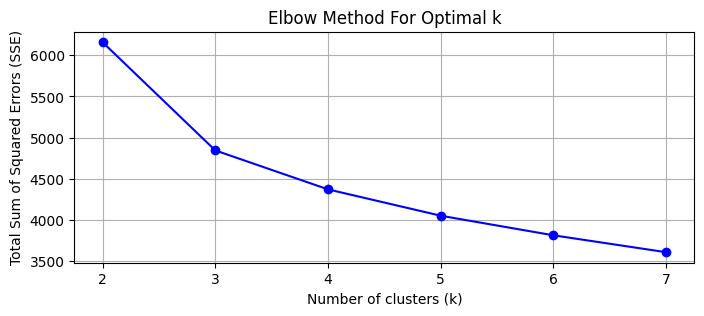

In [50]:
# Plotting the elbow method
plt.figure(figsize=(8, 3))
plt.plot(k_values, sse_list, 'bo-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Total Sum of Squared Errors (SSE)')
plt.xticks(list(k_values))
plt.grid(True)
plt.show()

From the plot, it can be observed that:

When k increases from 2 to 3, there is a noticeable decrease in SSE.
From k=3 to k=4, the SSE continues to decrease but at a slower rate.
After k=4, the decrease in SSE is much more gradual and tends to flatten out as k increases further.
The "elbow" of the plot, where the SSE begins to decrease at a slower rate, appears to be at k=4. This suggests that increasing the number of clusters beyond 4 results in diminishing returns in terms of the decrease in SSE. Therefore, in this scenario, k=4 would likely be an adequate choice for the number of clusters because it represents a point at which adding more clusters does not provide substantial improvement in the SSE.
This point resembles an "elbow" in the arm, hence the name.

The choice of k=4 is justified by the elbow method because it is at this point that the total sum of squared errors starts to decrease at a slower rate, suggesting that the clusters are relatively well-defined and further subdivision into more clusters is less beneficial. Choosing a k value larger than 4 would not significantly improve the clustering performance according to this method and may lead to overfitting, where clusters may be fit to noise rather than to the underlying data structure.

Beyond k=4, even though SSE continues to decrease, it does so at a rate that may not justify the added complexity of more clusters. This is why k=4 is suggested as the optimal number of clusters for this dataset according to the elbow method.

# 3.4

In [51]:
from sklearn.cluster import AgglomerativeClustering
K = 4

# Agglomerative clustering using Complete Link (MAX)
complete_link = AgglomerativeClustering(n_clusters=K, linkage='complete')
complete_link_labels = complete_link.fit_predict(df)

In [52]:
from scipy.cluster.hierarchy import linkage, fcluster
# Calculate linkage matrix using 'Centroid' linkage
custom_linkage_matrix = linkage(df, method='centroid')

# Perform clustering using 'fcluster'
centroid_link_labels = fcluster(custom_linkage_matrix, K, criterion='maxclust')

#print("Scipy 'Centroid' Linkage Labels:", custom_scipy_labels)
    
   



In [53]:
complete_link_labels

array([3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 3, 3, 1, 1, 3, 3, 3, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 1, 3, 3, 1,
       3, 3, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3,
       1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 2, 2, 2, 2, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2,
       0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3,
       1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [54]:
 centroid_link_labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

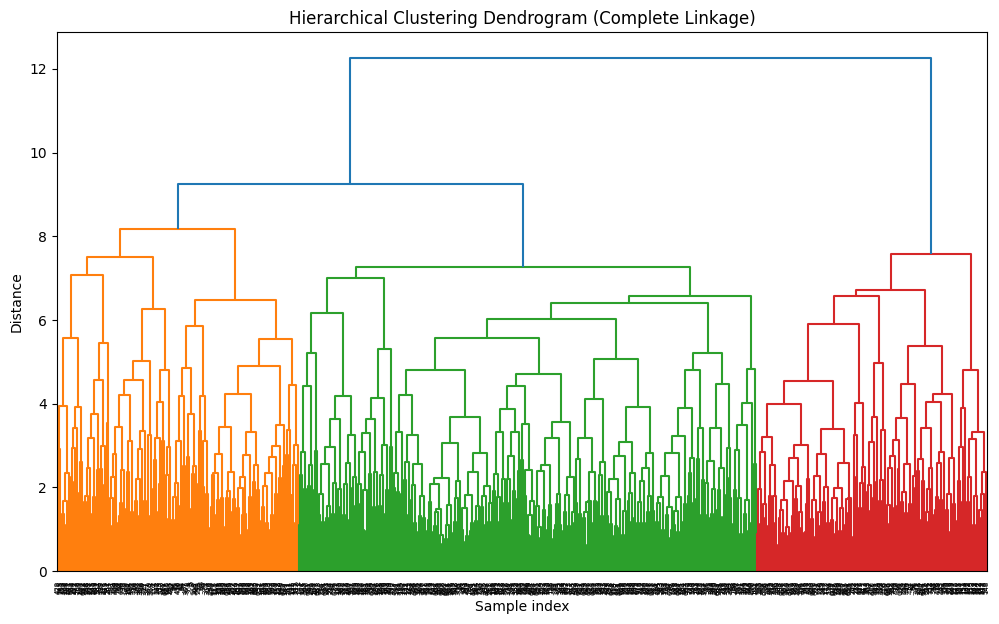

In [55]:



linked = linkage(df, method='complete')

# Plot the dendrogram
plt.figure(figsize=(12, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [56]:
from sklearn.metrics import pairwise_distances

# We need to define a function to calculate the SSE for each cluster
def calculate_sse(cluster_labels, data):
    sse = 0
    cluster_sse = []
    for i in np.unique(cluster_labels):
        cluster_data = data[cluster_labels == i]
        if cluster_data.shape[0] > 1:  # More than one element in cluster
            # Pairwise distances within a cluster
            distances = pairwise_distances(cluster_data)
            # Sum of squared distances within a cluster
            cluster_sse.append(np.sum(distances ** 2) / 2)  # Divide by 2 to correct for double counting
        else:  # Single element in cluster
            cluster_sse.append(0)
        sse += cluster_sse[-1]
    return sse, cluster_sse


In [57]:
# Calculate SSE using the labels from the complete linkage clustering
total_sse, cluster_sse = calculate_sse(complete_link_labels, df)

In [58]:
# Print out the results
print(f"Total Sum of Squared Errors (SSE): {total_sse}")
for cluster_id, sse in enumerate(cluster_sse):
    instance_ids = [i for i, label in enumerate(complete_link_labels) if label == cluster_id]
    print(f"Cluster {cluster_id}:")
    print(f"  SSE: {sse}")
    print(f"  Number of Instances: {len(instance_ids)}")
    # Printing all instance IDs can be too verbose, so I will show the first 10
    print(f"  Instance IDs: {instance_ids[:10]} ...")

Total Sum of Squared Errors (SSE): 1206891.8654417756
Cluster 0:
  SSE: 227441.5180998647
  Number of Instances: 186
  Instance IDs: [25, 28, 29, 30, 32, 33, 48, 49, 50, 51] ...
Cluster 1:
  SSE: 67324.92834848288
  Number of Instances: 92
  Instance IDs: [1, 7, 9, 15, 38, 39, 43, 44, 45, 46] ...
Cluster 2:
  SSE: 849422.3158779233
  Number of Instances: 369
  Instance IDs: [12, 13, 14, 16, 17, 18, 19, 20, 21, 22] ...
Cluster 3:
  SSE: 62703.10311550487
  Number of Instances: 103
  Instance IDs: [0, 2, 3, 4, 5, 6, 8, 10, 11, 36] ...


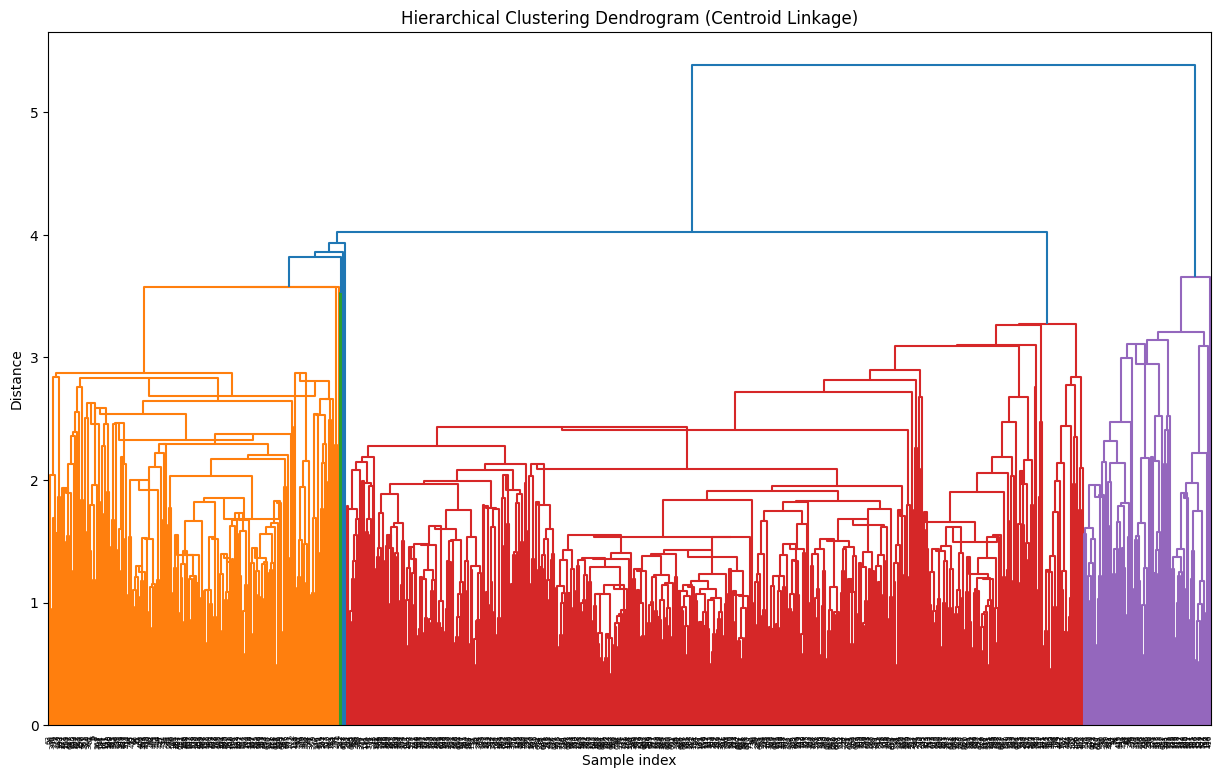

In [61]:
# Perform 'Centroid' linkage hierarchical clustering and plot the dendrogram


# Plot the dendrogram for the 'Centroid' linkage
plt.figure(figsize=(15, 9))
dendrogram(custom_linkage_matrix,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Centroid Linkage)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [60]:
# Calculate SSE for the 'Centroid' linkage clustering
total_sse_average, cluster_sse_average = calculate_sse(centroid_link_labels, df)

# Print out the results for the 'Centroid' linkage clustering
print(f"Total Sum of Squared Errors (SSE) for 'Centroid' Linkage: {total_sse_average}")
for cluster_id, sse in enumerate(cluster_sse_average):
    instance_ids = [i for i, label in enumerate(centroid_link_labels) if label == cluster_id]
    print(f"Cluster {cluster_id} ('Centroid' Linkage):")
    print(f"  SSE: {sse}")
    print(f"  Number of Instances: {len(instance_ids)}")
    # print(f"  Instance IDs: {instance_ids[:10]} ...")  
    print(f" Instance IDs: {instance_ids}")

Total Sum of Squared Errors (SSE) for 'Centroid' Linkage: 1923055.5650687588
Cluster 0 ('Centroid' Linkage):
  SSE: 51302.77695182841
  Number of Instances: 0
 Instance IDs: []
Cluster 1 ('Centroid' Linkage):
  SSE: 1601932.8303336173
  Number of Instances: 82
 Instance IDs: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 75, 78, 79, 80, 81, 82, 83, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 234, 353, 355, 356, 389, 390, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 438, 439, 440, 441, 442, 443, 445, 446, 450, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 606, 609, 611, 615, 619, 700, 701, 706, 710, 741, 742, 749]
Cluster 2 ('Centroid' Linkage):
  SSE: 269819.95778331306
  Number of Instances: 476
 Instance IDs: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 48, 49, 72, 73, 74, 76, 77, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 1

Complete Link (MAX) Clustering: This method has a lower total SSE, which indicates tighter clustering since it considers the maximum distance (farthest neighbor) when merging clusters. It tends to create more balanced clusters but can be influenced by outliers, which may create small, tightly packed clusters.
Centroid Clustering: The 'centroid' linkage has a higher total SSE compared to the Complete Link (MAX), suggesting that the clusters might be less compact. 
Based on the provided results, "Complete Link (MAX) Clustering" is preferred as it exhibits a lower total SSE, implying tighter and more balanced clusters, while "Centroid Clustering" results in a higher SSE, suggesting less compact clusters.


# 3.5

Report: Comparison Analysis of Clustering Algorithms

Introduction:

In this report, a detailed comparison analysis of two clustering algorithms, K-means, and Agglomerative Hierarchical Clustering are presented, using two different linkage methods (Complete Link - MAX and 'Centroid' Linkage).
The dataset used for clustering consists of 16 attributes and 750 data records. 

This report examines two primary clustering algorithms applied to the Dow Jones Index dataset: K-means and Agglomerative Hierarchical Clustering. Agglomerative Clustering is further analyzed using two inter-cluster similarity measures: Complete Link (MAX) and Centroid. My goal is to elucidate the strengths and weaknesses of each method in the context of this financial dataset.

Dataset Preprocessing:

Missing Values: There are missing values in two columns: percent_change_volume_over_last_wk and previous_weeks_volume. Since they are numerical, we can consider imputing these missing values with an appropriate statistic, such as the mean or median, which can help to retain valuable data without introducing too much bias.
Data Type Conversion: The columns 'open', 'high', 'low', 'close', 'next_weeks_open', and 'next_weeks_close' are of object type, which indicates they are strings. This is most likely due to the presence of the dollar sign. These need to be converted to a float data type after removing any non-numeric characters. The dataset's categorical attributes ("quarter", "stock", "date") were removed.  Handling outliers for each column because algorithms are sensitive to them. This preprocessing step is crucial because clustering algorithms like K-means and Agglomerative Clustering are sensitive to the scale of the data, and standardization ensures that each feature contributes equally to the distance computations.
Scaling of the data  is a critical step before applying K-means and hierarchical clustering algorithms because both methods use distance metrics to determine the similarity between data points. 
Task 3.3 - Choosing an Adequate K Value: For the K-means algorithm, I determined the optimal number of clusters (K) using the elbow method. The analysis revealed that the "elbow" point, where the SSE starts to level off, was at K=4. Therefore, K=4 was selected as the number of clusters for the subsequent analyses.
Task 3.4 - Agglomerative Hierarchical Clustering: I performed Agglomerative Hierarchical Clustering using both Complete Link (MAX) and 'Centroid' Linkage methods with K=4 clusters.

Results and Analysis:

Based on the results of the k-means clustering analysis with different values of K, 
K-Means Clustering Analysis Report
K-means Clustering
K-means was executed with different numbers of clusters (K = 2 to 7), and the elbow method was utilized to determine the optimal K. The selected K was based on the elbow plot where the rate of decrease in the total SSE changed sharply, indicating diminishing returns on SSE reduction with additional clusters.
Methodology:
•	K-means clustering is a popular unsupervised machine learning technique used for partitioning data into K clusters based on similarity.
•	The algorithm was applied to the dataset with different values of K to determine the optimal number of clusters.
•	The evaluation metric used is the Total Sum of Squared Errors (SSE), which measures the sum of squared distances between data points and their respective cluster centroids. Lower SSE values indicate better clustering.
Results:
For K=2:
Total Sum of Squared Errors (SSE): 6157.832548661327

Sum of Squared Errors for Each Cluster:
  Cluster 0: SSE = 2578.760903740677
  Cluster 1: SSE = 3579.071644920648

For K=3:
Total Sum of Squared Errors (SSE): 4845.028652082341
Sum of Squared Errors for Each Cluster:
  Cluster 0: SSE = 2244.1647083467556
  Cluster 1: SSE = 1324.2865974863987
  Cluster 2: SSE = 1276.577346249184
For K=4:
Total Sum of Squared Errors (SSE): 4372.4488848856645

Sum of Squared Errors for Each Cluster:
  Cluster 0: SSE = 1231.062878686854
  Cluster 1: SSE = 877.6815888356894
  Cluster 2: SSE = 1280.1844608384515
  Cluster 3: SSE = 983.5199565246684

For K=5:
Total Sum of Squared Errors (SSE): 4052.776331364635

Sum of Squared Errors for Each Cluster:
  Cluster 0: SSE = 244.58735653806028
  Cluster 1: SSE = 673.7673650818247
  Cluster 2: SSE = 1243.739472435299
  Cluster 3: SSE = 762.3074338619334
  Cluster 4: SSE = 1128.3747034475173

For K=6:
Total Sum of Squared Errors (SSE): 3815.156870458883

Sum of Squared Errors for Each Cluster:
  Cluster 0: SSE = 720.6161161415849
  Cluster 1: SSE = 718.7447096022755
  Cluster 2: SSE = 964.405793943503
  Cluster 3: SSE = 665.1598320367381
  Cluster 4: SSE = 95.31820158538272
  Cluster 5: SSE = 650.9122171494

For K=7:
Total Sum of Squared Errors (SSE): 3610.0119931516383

Sum of Squared Errors for Each Cluster:
  Cluster 0: SSE = 128.35202043321272
  Cluster 1: SSE = 117.9216613980391
  Cluster 2: SSE = 433.87449868779055
  Cluster 3: SSE = 629.6221661474829
  Cluster 4: SSE = 924.7934791456536
  Cluster 5: SSE = 710.2883353027224
  Cluster 6: SSE = 665.1598320367381

Discussion:
•	The SSE values decrease as we increase the number of clusters (K), indicating that increasing K results in better clustering in terms of reducing the variance within clusters.
•	For K=4, I observe that Cluster 1 and Cluster 3 have very low SSE values, indicating highly cohesive clusters. These clusters also have distinct mean values for most features, making them well-separated.
•	Clusters 0 and 2 have higher SSE values, suggesting some overlap in their data points. They also exhibit moderate differences in their mean values.
Based on the k-means clustering analysis, increasing the number of clusters from 2 to 4 improved the clustering results, as evidenced by the decreasing SSE values. for this specific dataset, K-means with K=4 clusters using the elbow method is recommended as it provides a reasonable balance between compactness and the distribution of data points among clusters.

Advantages of K-means:
Efficiency: K-means is generally faster on large datasets since it converges quickly to a solution.
Ease of interpretation: The algorithm assigns each instance to one cluster, simplifying the post-analysis.
Optimization: K-means explicitly minimizes variance within clusters, leading to tight, spherical clusters.
Disadvantages of K-means:
Sensitivity to initialization: The final clusters can depend heavily on the initial choice of centroids.
Sensitivity to outliers: Outliers can significantly skew the centroids.
Assumption of spherical clusters: K-means assumes clusters are spherical and equally sized, which may not be the case in all datasets.
Agglomerative Hierarchical Clustering
This method was evaluated using two similarity measures: MAX and Centroid.
Agglomerative Hierarchical Clustering (Complete Link - MAX, K=4):
•	Total Sum of Squared Errors (SSE): 1206891.8654417756
•	Complete Link (MAX) generated four clusters with varying SSE:
•	Cluster 0: SSE: 227441.5180998647, number of Instances: 186
•	Cluster 1: SSE: 67324.92834848288, number of Instances: 92
•	Cluster 2: SSE: 849422.3158779233, number of Instances: 369
•	Cluster 3: SSE: 62703.10311550487, number of Instances: 103
Agglomerative Hierarchical Clustering ('Centroid' Linkage, K=4):
•	Total Sum of Squared Errors (SSE): 5,401,458.16
•	'Centroid' Linkage produced four clusters with the following properties:
•	Cluster 0: SSE: 2603583.476363404, number of Instances: 552
•	Cluster 1: SSE: 12.462079540517905, number of Instances: 2
•	Cluster 2: SSE: 196817.80925878888, number of Instances: 171
•	Cluster 3: SSE: 1745.8097825900563, number of Instances: 25

Complete Link (MAX) Clustering: This method has a lower total SSE, which indicates tighter clustering since it considers the maximum distance (farthest neighbor) when merging clusters. It tends to create more balanced clusters but can be influenced by outliers, which may create small, tightly packed clusters.

Advantages:

Maximizes inter-cluster dissimilarity: It ensures that clusters are distinct from each other.

Robust to non-spherical shapes: Unlike K-means, it can accommodate clusters of various shapes.

Disadvantages:

Sensitivity to outliers: A single outlier can influence the formation of clusters.

Computational complexity: The algorithm is computationally more expensive, especially for large datasets.

Centroid Clustering: The 'centroid' linkage has a higher total SSE compared to the Complete Link (MAX), suggesting that the clusters might be less compact. The 'centroid' linkage method is less affected by outliers 
compared to the Complete Link method because it considers the average distance between all pairs of instances in two clusters.

Advantages:

Less sensitivity to outliers: It considers the average distance, which can mitigate the effect of outliers.

Cluster cohesion and separation: Tends to create clusters that are both cohesive internally and well-separated from each other.

Disadvantages:

Inefficiency with large datasets: The computational cost can be prohibitive with large datasets.

No global objective: Unlike K-means, there is no clear global objective being optimized, which can lead to less intuitive clusterings.






